In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'corel-images:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F462387%2F869652%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240311%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240311T092627Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2a31023455a01de042d501e9a5b91a479cd2991dde0bade0b3164a417d6eb2ecf4d796f47d57e4079dac917f58ecc764f0f02610d37296343711e81dfe592ca874800f64a0dfe7a7076881aacd16cfa7a9699c6cc98b9268547e6c1996047554911c687e9d603fa7d3a1ba915f2f2c18d38ca9da0cc7adf949c1d653acc0204dfdec46654313f4d16e16005557a1398bbd8ac17f445bb85dacdb496a22c59872d1602e93f97ffa100518fe11d0565de4b55043012fecfeb4c35b22349ca982cfb3374002fedca592dcb8602ab3d6c7b57a0fba7b300f62eaaffde5f927900614fd6f0a6feb3b4770a7100176b0ab169fab3b8aeaf7b528b57ae7f6fda7f8de08,corel1k-features:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1524444%2F2516606%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240311%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240311T092627Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1a99b9543f0a251bbe4b61063befdb378e4010b554bff022962d338190da1a313a5517e7a1a34da1f8118afa6e8a68cb5a612607b81114a318f3c3fc96ba6d0967f2d95ad6f9e3681309c40d591e1c84d6d5235b6b832641b9a876d098f53d2bc8e81eddddb93c9dc0b2195c18e9429f2d036cc04fe2cf41f07d8b77c39c42cfffcf85a551023242ec389ecfb97cbf12a13465ff36a81190478c85918028d4e57f1f72f301df7e43ea3023879d4cc4b392e521a6df0934d1572d5f768a219cd2304fb0a5e7272b6cdffdb2ea47e6aa048275c21c3fa01ca2424b947a3785d15fe13552fd19c47566e69ce554c26e5ea0485da41aa7874ef3cea5460e801a811e'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 29867737 bytes downloaded
Downloaded and uncompressed: corel-images
[==================================================] 6127293 bytes downloaded
Downloaded and uncompressed: corel1k-features
Data source import complete.


In [ ]:
# CODE BEGINS FROM HERE
import pickle
import numpy as np
import matplotlib.pyplot as plt
import time
from numpy.linalg import norm
import matplotlib.image as mpimg
import random
from sklearn.cluster import KMeans
from math import floor
import math
from scipy import spatial
from sklearn.decomposition import PCA

### Loading features


In [ ]:
# Importing the pre-computed features of caltech dataset
images = pickle.load(open('/kaggle/input/corel1k-features/features-corel1k_features.pickle' , 'rb'))
images = np.asarray(images)
print(images.shape)

# Importing the address of each image in caltech dataset
files = pickle.load(open('/kaggle/input/corel1k-features/filenames-corel1K.pickle' , 'rb'))
print(files[0])

(900, 2048)
/media/iitp/SAMSUNG/datasets/corel1k/dataset/training_set/beaches/110.jpg


In [ ]:
# Modifying the address according to kaggle requirements (required to display images else not required)
filenames = []
for i in range(len(files)):
    z = files[i]
    y = files[i].split("/dataset/")
    z = '/kaggle/input/corel-images/dataset/' + y[-1]
    filenames.append(z)
print(filenames[0])

/kaggle/input/corel-images/dataset/training_set/beaches/110.jpg


In [ ]:
for i in range(len(filenames)):
    print(i,filenames[i])

In [ ]:
from sklearn.decomposition import PCA
print(images.shape)
pca = PCA(n_components = 100)
images = pca.fit_transform(images)
print(images.shape)

(900, 100)
(900, 100)


### Extracting class information of images

In [ ]:
'''finding number of images in each class'''  # required for computing recall

total_class_count = {}
COUNT=[]

for i in range(len(filenames)):
    x = filenames[i].split("/")
    a = x[-2:-1]

    if(a[0] in total_class_count):
        total_class_count[a[0]] = total_class_count[a[0]] + 1
    else:
        total_class_count[a[0]] = 1

for j in total_class_count:
    COUNT.append(total_class_count[j])

print(total_class_count)
print(len(COUNT))

{'beaches': 90, 'bus': 90, 'dinosaurs': 90, 'elephants': 90, 'flowers': 90, 'foods': 90, 'horses': 90, 'monuments': 90, 'mountains_and_snow': 90, 'peolpe_and_villages_in_Africa': 90}
10


In [ ]:
'''CLASS START INDEX'''   # required for clustering
class_start_index = []
count = 0
for i in range(len(COUNT)+1):
    if(i < len(COUNT)):
        class_start_index.append(count)
        count = count + COUNT[i]
    else:
        count = len(filenames)
        class_start_index.append(count)
        break

num_of_class = len(class_start_index)
print(class_start_index)

[0, 90, 180, 270, 360, 450, 540, 630, 720, 810, 900]


In [ ]:
def ClusterIndicesNumpy(clustNum, labels_array): #numpy
    return np.where(labels_array == clustNum)[0]

### Clustering

In [ ]:
'''dividing the data/features of each class into clusters'''

clusters = [[] for j in range(len(COUNT))]
represent_points = [[] for j in range(len(COUNT))]


class_index = class_start_index
class_index.append(len(filenames))


for i in range(0,len(COUNT)):
    start = class_start_index[i]                 # starting index of features to be considered for clustering (starting index of a class)
    end = class_start_index[i+1]                 # ending index of features to be considered for clustering (end index of a class)
    n_clusters = floor((end-start) * (20/100))   # number of clusteres to be formed is 20% of the entire dataset (can be varied)

    if(n_clusters<1):
        n_clusters = 1

    print(end-start,i, n_clusters)

    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
    pred_y = kmeans.fit_predict(images[start:end])

    for n in range(n_clusters):
        a = ClusterIndicesNumpy(n, kmeans.labels_)
        clusters[i].append(list(a))

    represent_points[i].extend(kmeans.cluster_centers_)

90 0 18
90 1 18
90 2 18
90 3 18
90 4 18
90 5 18
90 6 18
90 7 18
90 8 18
90 9 18


In [ ]:
#Save clusters and representative points (cluster heads) to reduce computation in future runs if necessary.

# clusters = pickle.load(open('data_files/caltech_256_files/clusters_20.pickle','rb'))
# represent_points = pickle.load(open('data_files/caltech_256_files/represent_points_20.pickle','rb'))


In [ ]:
print(len(represent_points), len(represent_points[0]), len(represent_points[0][0]))

10 18 100


## Searching : level 1
Returns top 1 classes

In [ ]:
def image_search(query_features,top_k_class):

    distance = [[] for j in range(num_of_class)]


    for i in range(len(represent_points)):
        for j in range(len(represent_points[i])):
            d = np.linalg.norm(represent_points[i][j] - query_features)
            distance[i].append(d)

    dist=[]
    class_name = []

    for i in range(len(COUNT)):
        dist.append(min(distance[i]))

    for i in range(top_k_class):
        ind = dist.index(min(dist))
        class_name.append(ind)
        dist[ind] = 10000

    return class_name

## Searching level 2:

In [ ]:
def fine_search(query_features,class_names,top_k):
    dist = []
    k = []

    class_index = class_start_index

    for l in range(top_k):
        dist.append(10000 * (l+1) )
        k.append(0)

    for i in range(len(class_names)):
        for j in range(class_index[class_names[i]] , class_index[class_names[i]+1]):
            d = np.linalg.norm(query_features - images[j])
#             print(d,j)
            if(d < max(dist) ):
                maxpos = dist.index(max(dist))

                dist.remove(max(dist))
                dist.append(d)

                k.pop(maxpos)
                k.append(j)
    return k

In [ ]:
test = []
for i in range(10):
    k = random.randint(0, (len(filenames)-1))
    test.append(k)

print(test)
# [673, 34, 742, 35, 540, 760, 750, 439, 205, 578]

[679, 298, 693, 831, 14, 443, 112, 417, 691, 181]


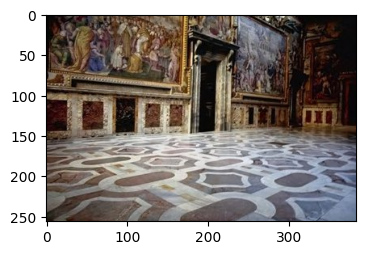

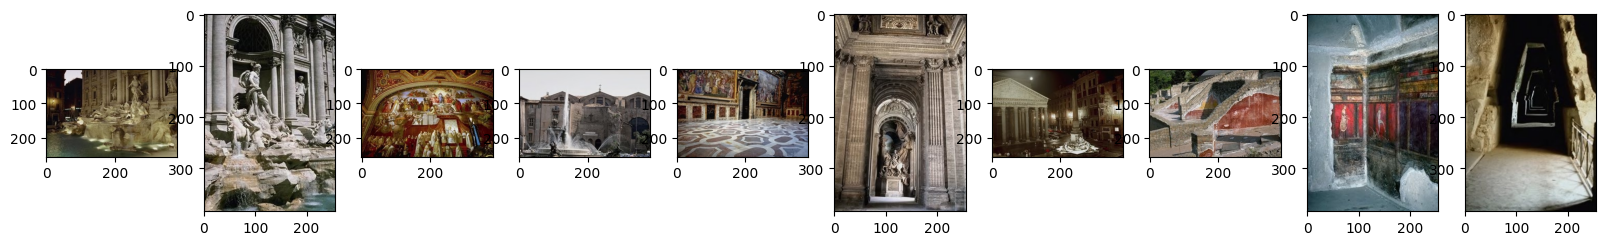

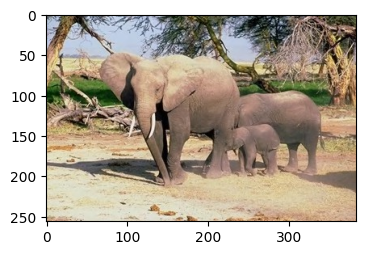

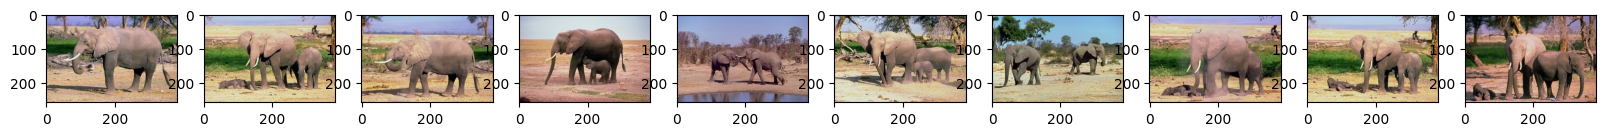

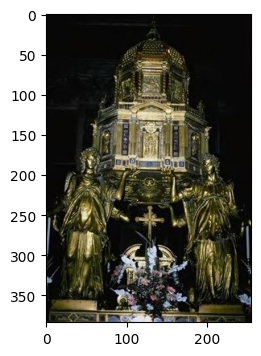

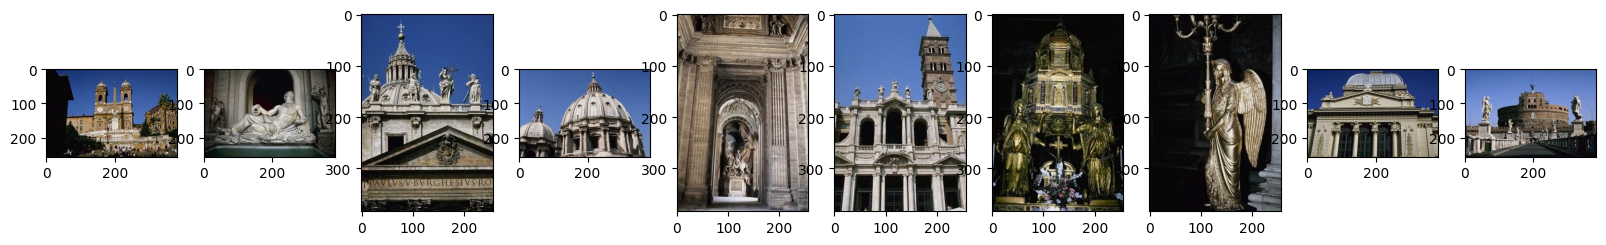

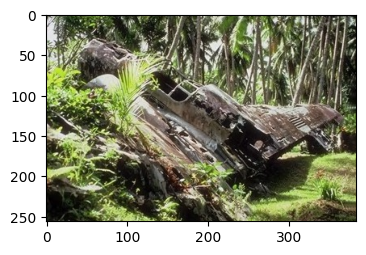

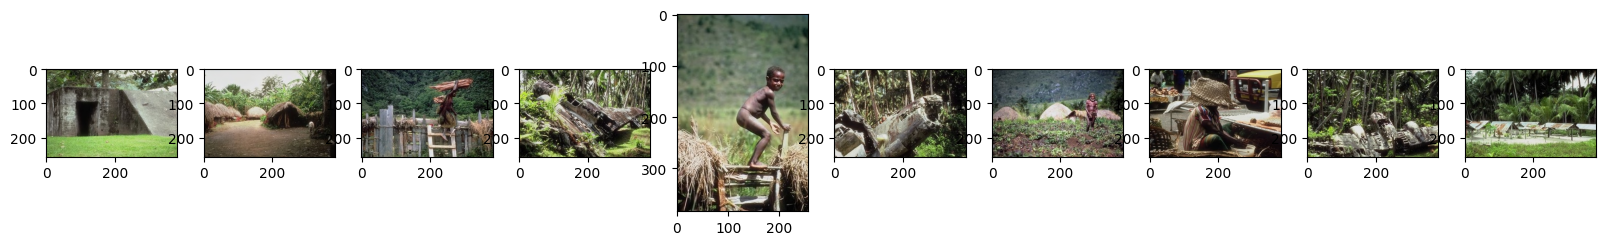

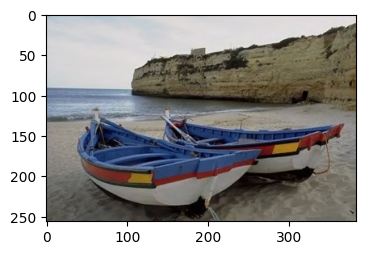

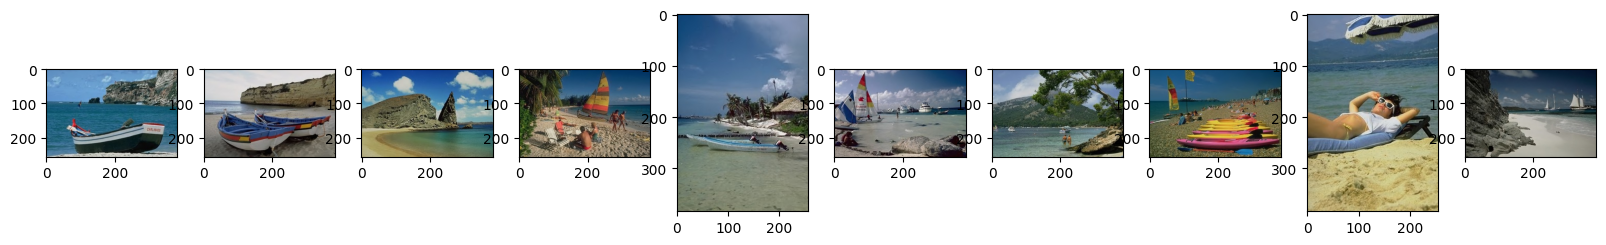

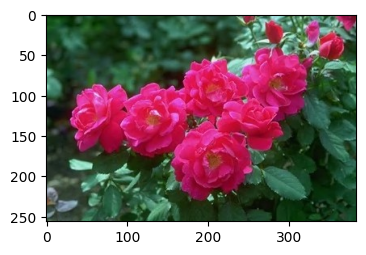

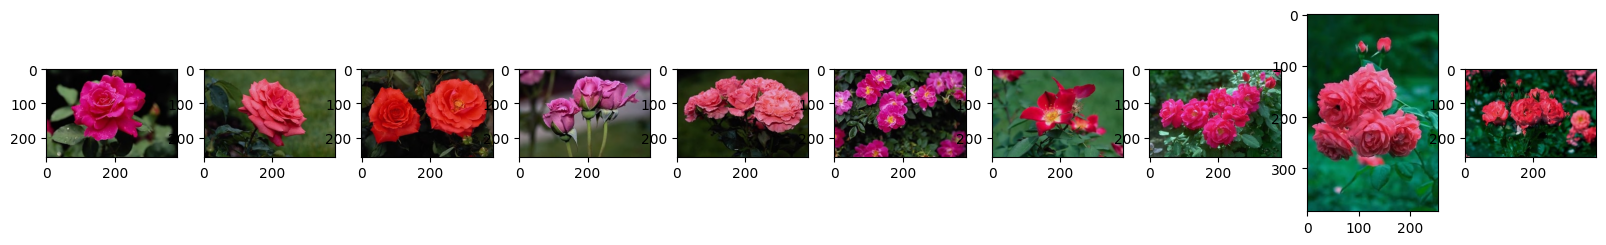

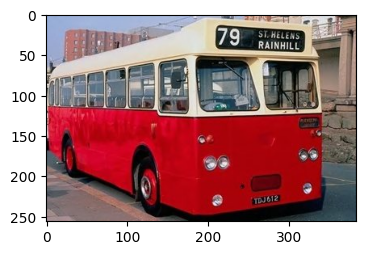

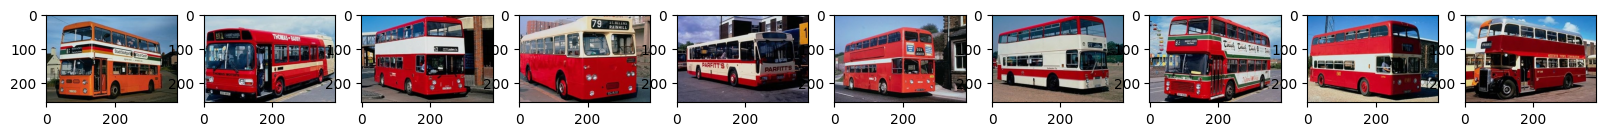

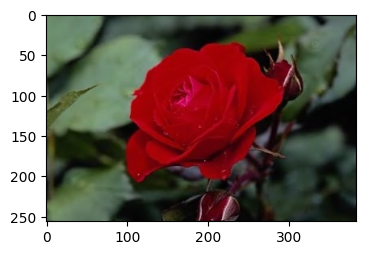

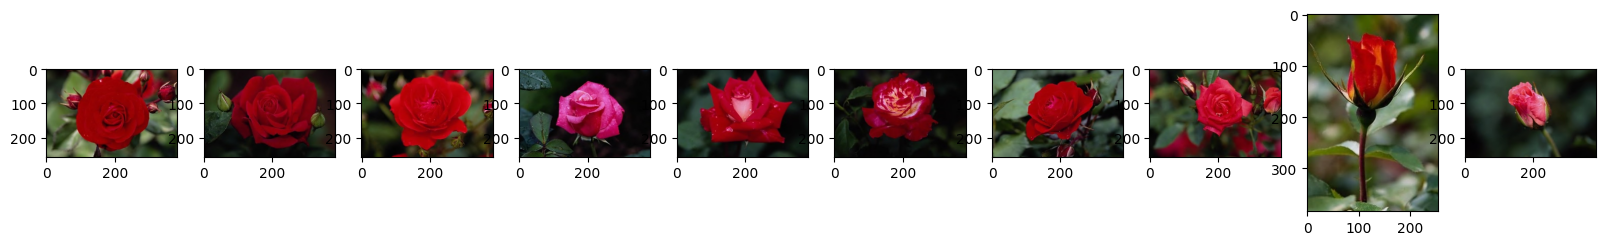

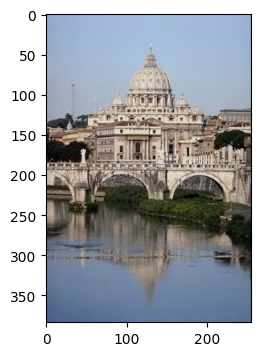

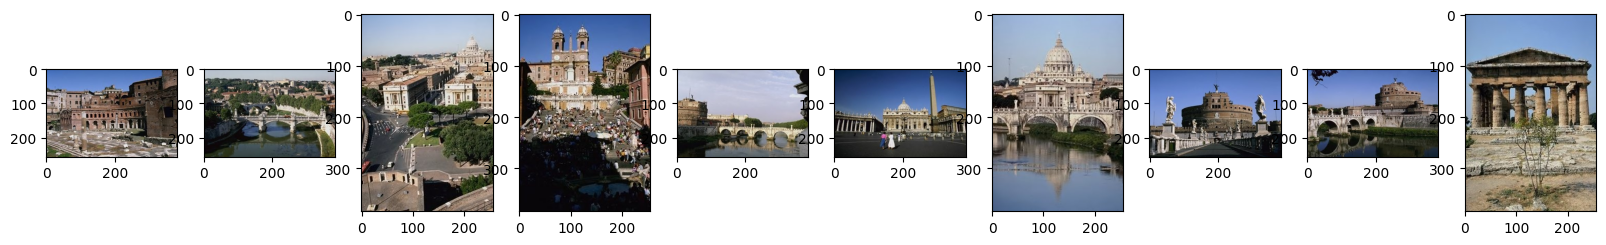

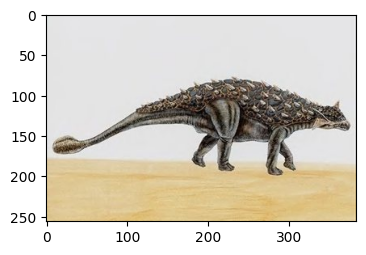

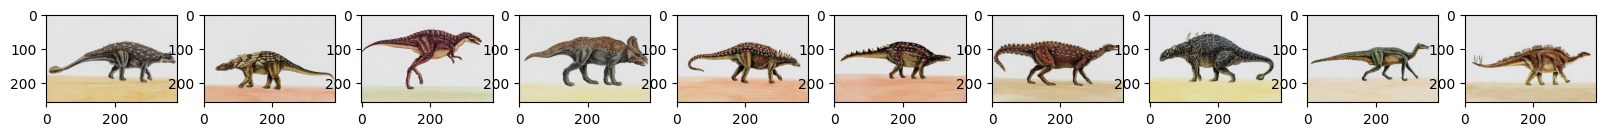

In [ ]:
''' for reverse image retrieval'''

for k in range(len(test)):
    top_k = 10

    result = image_search(images[test[k]],1)
    index = fine_search(images[test[k]],result,top_k)

    # displaying the query image
    plt.figure(figsize=(4,4))
    img = mpimg.imread(filenames[test[k]])
    plt.imshow(img)
    plt.show()

    # displaying the results obtained
    plt.figure(figsize=(15,15))
    for i in range(len(index)):
        plt.subplot(1,10,i+1)
        img = mpimg.imread(filenames[index[i]])
        plt.imshow(img)
    plt.show()